In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.spatial.distance import cdist
import time
import csv

In [55]:
import matplotlib.pyplot as plt

In [86]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [87]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [88]:
df = df[df.LATITUDE.notnull()]

In [24]:
df['LOCATION'] = [(float(x), (y)) for x,y in zip(df['LATITUDE'], df['LONGITUDE'])]

In [6]:
stations = pd.read_csv(path + "wunderground_stations.csv")
stations['LOCATION'] = [(x, y) for x,y in zip(stations['lat'], stations['long'])]

In [9]:
stations = stations[stations['station'] != 'KJRB']

In [10]:
stations

,station,lat,long,name,LOCATION
0,KEWR,40.689531,-74.174462,Newark International,"(40.689531, -74.174462)"
1,KFRG,40.726129,-73.416781,Republic,"(40.726129, -73.416781)"
2,KISP,40.789845,-73.097568,Long Island Mac Arthur,"(40.789845, -73.097568)"
3,KJFK,40.641311,-73.778139,John F. Kennedy International,"(40.641311, -73.778139)"
5,KLGA,40.776927,-73.873966,LaGuardia Airport,"(40.776927, -73.873966)"
6,KNYC,40.782865,-73.965355,Central Park,"(40.782865, -73.965355)"
7,KTEB,40.859822,-74.059307,Teterboro,"(40.859822, -74.059307)"


In [11]:
points = list(stations['LOCATION'])

def closest_station(point):
    """ Find closest point from a list of points. """
    minpt = cdist([point], points).argmin()
    return list(stations['station'])[minpt]

In [12]:
df['station'] = [closest_station(x) for x in df.LOCATION]

In [13]:
df.groupby('station')['UNIQUE KEY'].count()

station
KEWR    246961
KISP        25
KJFK    131551
KLGA    236175
KNYC    379787
Name: UNIQUE KEY, dtype: int64

In [5]:
weather = pd.read_csv(path + "wunderground_weather.tsv", delimiter='\t', parse_dates=[['date', 'time']], infer_datetime_format=True)

In [64]:
def closest_time(station, time):
    search = weather[weather['station']==station]['date_time'].searchsorted(time)[0]
    index = weather[weather['station']==station].iloc[search].name
    return index

In [77]:
weather_index = []

i = 0
start_time = time.time()

for x,y in zip(df['station'], df['DATE_TIME']):
    weather_index.append(closest_time(x, y))
    i += 1
    
    if i % 100 == 0:
        elapsed_time = time.time() - start_time
        print '%s rows completed, approximate time remaining: %s' % (i, elapsed_time/float(i)*(792851 - i))

792851


In [100]:
weather_join

[49934,
 49934,
 49934,
 255680,
 194503,
 209840,
 209841,
 49935,
 44667,
 49935,
 49935,
 255681,
 162148,
 255681,
 209841,
 255681,
 255681,
 49935,
 209841,
 204809,
 204809,
 49935,
 49935,
 209841,
 162148,
 162148,
 209841,
 49935,
 204811,
 204811,
 204811,
 49936,
 49936,
 209842,
 49936,
 209842,
 49936,
 250919,
 44671,
 255682,
 209842,
 49936,
 49936,
 209842,
 49936,
 255682,
 250921,
 209842,
 49936,
 49936,
 49936,
 49936,
 255682,
 49936,
 250923,
 240957,
 157275,
 250924,
 255683,
 209843,
 49937,
 49937,
 49937,
 209843,
 49937,
 49937,
 49937,
 44675,
 49937,
 255683,
 209843,
 49937,
 49937,
 255683,
 49937,
 49937,
 44676,
 44676,
 49937,
 49937,
 162150,
 49937,
 49937,
 49937,
 49937,
 204800,
 204801,
 204801,
 44659,
 209844,
 49938,
 49938,
 209844,
 49938,
 162151,
 49938,
 49938,
 255684,
 49938,
 49938,
 49938,
 209089,
 250910,
 204802,
 250911,
 44661,
 204802,
 209844,
 209844,
 209844,
 49938,
 49938,
 209089,
 49178,
 44637,
 198061,
 37582,
 37582

In [89]:
with open('weather_joined.pkl', 'rb') as myfile:
    weather_join = pickle.load(myfile)

In [90]:
df['weather_join_index'] = weather_join
df = df.join(weather, on='weather_join_index',  how='left')

In [35]:
df['difference_time'] = df.date_time-df.DATE_TIME

In [49]:
df['minutes_diff'] = df['difference_time'].dt.components['minutes'] + 60*df['difference_time'].dt.components['hours']

In [50]:
%matplotlib inline

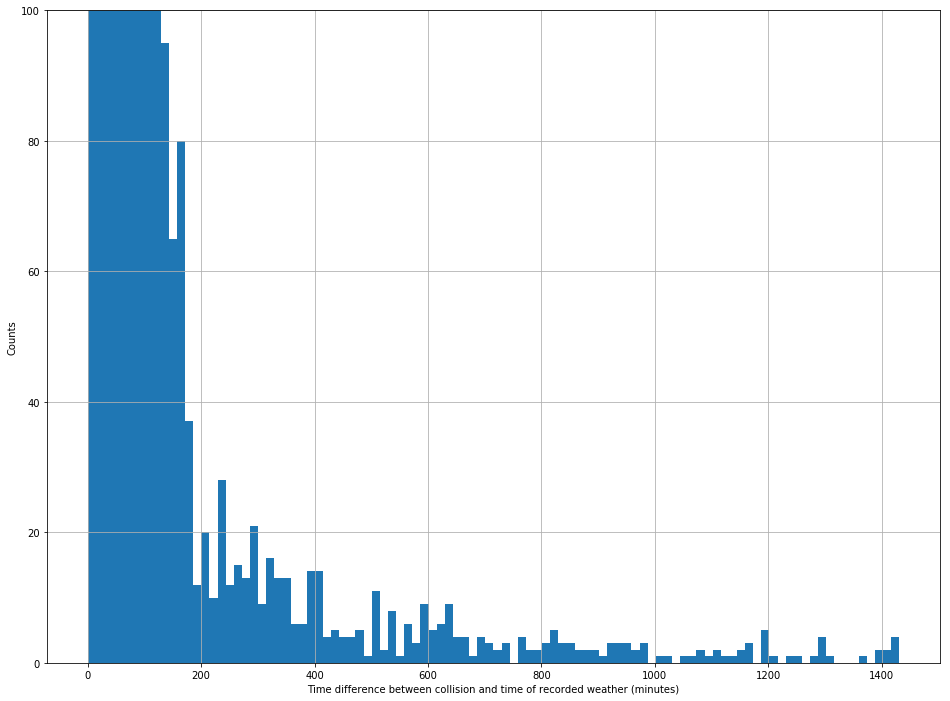

In [59]:
plt.figure(figsize=(16,12))
df['minutes_diff'].hist(bins=100)
plt.ylim([0,100])
plt.xlabel('Time difference between collision and time of recorded weather (minutes)')
plt.ylabel('Counts')

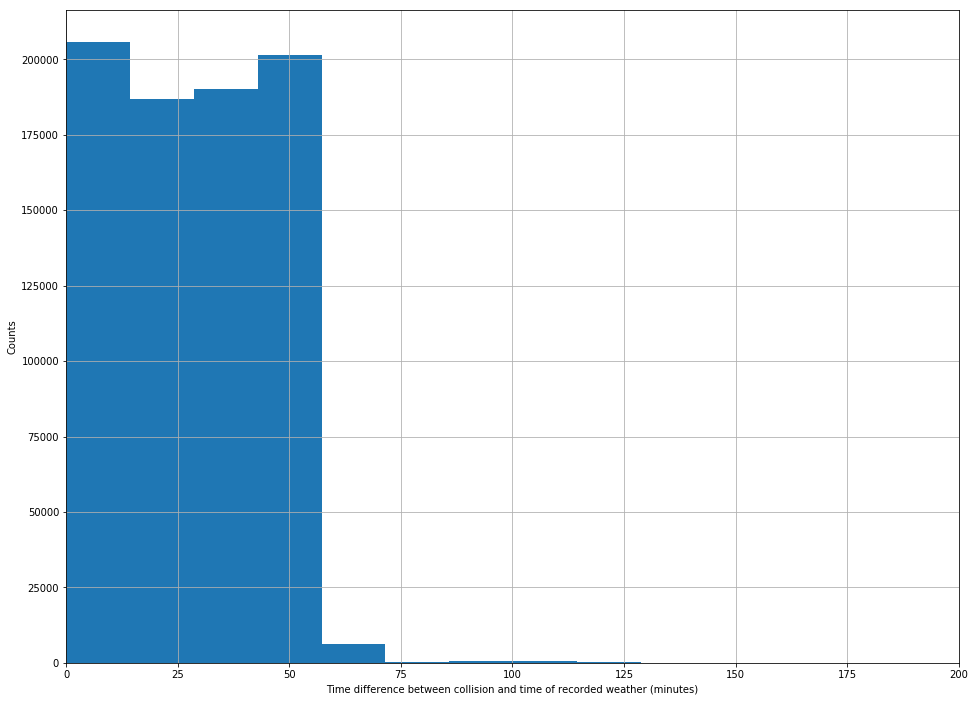

In [62]:
plt.figure(figsize=(16,12))
df['minutes_diff'].hist(bins=100)
plt.xlim([0,200])
plt.xlabel('Time difference between collision and time of recorded weather (minutes)')
plt.ylabel('Counts')

In [65]:
len(df[df['minutes_diff'] > 60])

2719

In [64]:
len(df[df['minutes_diff'] > 180])

423

In [91]:
df = df.set_index(['UNIQUE KEY'])

In [92]:
df = df.loc[:,['temperature', 'heat_index', 'dew_point',
       'humidity', 'pressure', 'visibility', 'wind_dir', 'wind_speed',
       'gust_speed', 'precip', 'events', 'conditions']]

In [93]:
df['events'].unique()

array([' ', 'Rain', 'Fog', 'Thunderstorm', 'Rain,Thunderstorm', 'Fog,Snow',
       'Snow', 'Fog,Rain', 'Rain,Snow', 'Fog,Rain,Thunderstorm'], dtype=object)

In [94]:
df['Rain'] = ['Rain' in i for i in df['events']]
df['Thunderstorm'] = ['Thunderstorm' in i for i in df['events']]
df['Snow'] = ['Snow' in i for i in df['events']]
df['Fog'] = ['Fog' in i for i in df['events']]
df['temperature'] = [i.strip(' F') for i in df.temperature]
df['heat_index'] = [i.strip(' F') for i in df.heat_index]
df['dew_point'] = [i.strip(' F') for i in df.dew_point]
df['humidity'] = [i.strip('%') for i in df.humidity]
df['pressure'] = [i.strip(' in') for i in df.humidity]
df['visibility'] = [i.strip(' mi') for i in df.visibility]
df['wind_speed'] = [i.strip(' mph') for i in df.wind_speed]
df['gust_speed'] = [i.strip(' mph') for i in df.gust_speed]
df['precip'] = [str(i).strip(' in') for i in df.precip]

In [96]:
df = df.drop(['events'], axis=1)

In [99]:
with open('final_weather_joined.pkl', 'wb') as output:
    pickle.dump(df, output, pickle.HIGHEST_PROTOCOL)